### Adaptive MCMC

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 150

This notebook presents a fairly simple approach to *adaptive* MCMC which is nonetheless fairly effective for moderate dimensions (numbers of parameters less than, say 10 or so).

Since the code is much the same as in previous notebooks, I have place it in a module, MCMCutils.py, but I will describe the changes here.

As usual, our goal is to explore the posterior probability distribution of a vector of parameters $\mathbf{w}$ given by Bayes' theorem:
$$ p(\mathbf{w}|D) = \frac{p(D|\mathbf{w})p(\mathbf{w})}{p(D)} $$
where $p(\mathbf{w})$ is our prior pdf and $p(D|\mathbf{w})$ is the likelihood.

We will continue to use our simple eclipsing exoplanet model in which the data $D$ are
a set of $N$ meaurements of magnitude as a function of time $\left\{(t_i,M_i)\right\}$, possibly with some errors $\sigma_i$ on the magnitudes (and with essentially no error in the determination of the $t_i$).

The model function is the same as before
$$ M(t) = \left\{\begin{array}{ll} M-\Delta m, &p_e-\frac{\Delta p}{2} < mod(t,P) < p_e +\frac{\Delta p}{2} \\
0, & \textrm{else} \end{array}\right. $$
where the $mod$ function represents "folding" the time *modulo* some period $P$. The parameter vector for the model is $\mathbf{w} = (M, \Delta m, \Delta p, p_e, P)$, with the possible addition of an uncertainty $\sigma$ on the $M_i$. These are the unoccluded stellar magnitude $M$, the depth of the eclipse $\Delta m$, the duration of the eclipse $\Delta p$
(measured in units of phase), the phase of the midpoint of the eclipse $p_e$, and the eclipse period $P$.

We will use Metropolis-Hastings to sample $p(\mathbf{w}|D)$ and thus do not need to know the normalization $p(D)$. Given our prior $p(\mathbf{w})$, the key ingredients are a method for proposing new steps in our Markov chain and a functional form for the likelihood function $p(D|\mathbf{w})$.

Assuming that we are in a measurement regime where the errors in the $M_i$ are normally distributed, we will take the usual sum-of-squares function for the log likelihood
$$ \log\mathcal{L} = -\frac{N}{2} \ln(2\pi) - \ln\left(\sum_{i=1}^N \sigma_i\right)
- \frac{1}{2} \sum_{i=1}^N \left( \frac{M_i - M(t_i, \mathbf{w})}{\sigma_i} \right)^2
$$
or, if we include the measurement error $\sigma$ as a parameter to sample instead of using $\sigma_i$,
$$ \log\mathcal{L} = -\frac{N}{2} \ln(2\pi) - \frac{N}{2}\ln(\sigma^2)
- \frac{1}{2} \sum_{i=1}^N \left(M_i - M(t_i, \mathbf{w})\right)^2 $$

Previously, we have proposed moves to $\mathbf{w}$ by drawing them component-by-component
from a normal distribution whose variance was a given parameter. The difficulty with this method was to determine a scale for the jumps in the different $w_i$ and to take into account the covariance between jumps in different components.

In this version of MCMC, we will draw our moves from a $k$-dimensional multivariate normal distribution
$$ p(\mathbf{x}) = \mathcal{N}_k(\boldsymbol{\mu},\mathbf{\Sigma}) = \left[(2\pi)^k |\mathbf{\Sigma}|\right]^{-1/2}
\exp\left\{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right\}
$$
where $k$ is the number of parameters in $\mathbf{w}$. Here $\mathbf{\Sigma}^{-1}$ is the inverse of the covariance matrix $\mathbf{\Sigma}$ on the components of $\mathbf{w}$
$$ \Sigma_{ij} = \mathrm{cov}[X_i, X_j] = E[(X_i-E[X_i])(X_j-E[X_j])] $$
and $|\mathbf{\Sigma}|$ is its determinant.

If we knew the covariance matrix $\mathbf{\Sigma}(\mathbf{w})$ and the means $\boldsymbol{\mu} = E[\mathbf{w}]$, then this would lead to a higher acceptance fraction while still providing wide coverage of the posterior distribution. For example, say our posterior distribution was the Rosenbrock density used in an earlier example:
$$ \rho(x,y; a, b) = \exp\left\{-\frac{(a-x_1)^2 + b(x_2-x_1^2)^2}{20}\right\} $$

If we sampled from the product of two normal distributions, one in $x$ and one in $y$, the best we can do is something like

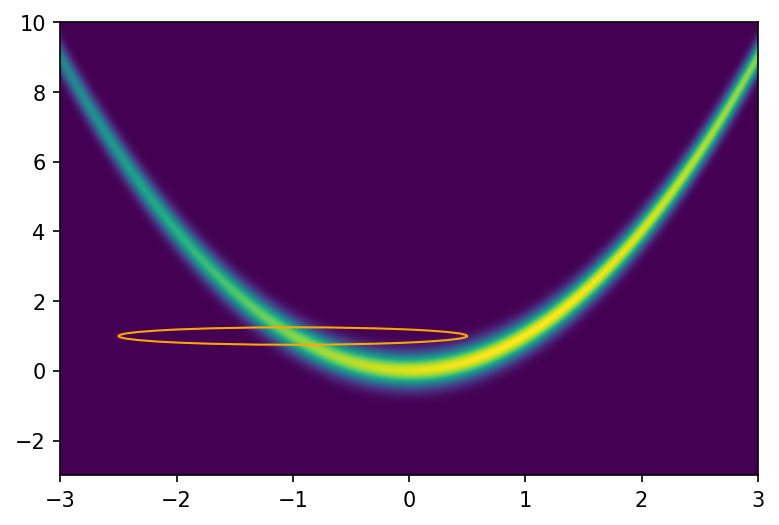

In [2]:
from matplotlib.patches import Ellipse


def rosen(x,y,a,b):
    return np.exp(-((a-x)**2+b*(y-x**2)**2)/20)

a, b = 1, 100
xmin,xmax = -3,3
ymin,ymax = -3,10
x1d = np.linspace(xmin,xmax, 1000)
y1d = np.linspace(ymin,ymax, 1000)
X,Y = np.meshgrid(x1d, y1d)
rho = rosen(X,Y,a,b)

fig,ax = plt.subplots()
im = ax.imshow(rho, vmin=0, vmax=1, extent=(xmin,xmax,ymin,ymax), origin='lower')
ax.set_aspect('auto')

ax.add_artist(Ellipse(xy = (-1,1), width=3.0, height=0.5, angle=0, fc='None', ec='orange'));

If, instead, we take as our covariance matrix $\mathbf{\Sigma} = \sigma^2(\mathbf{J}\mathbf{J}^T)^{-1}$ where $\mathbf{J}$ is the Jacobian of $\rho(x,y)$,
we could sample instead from

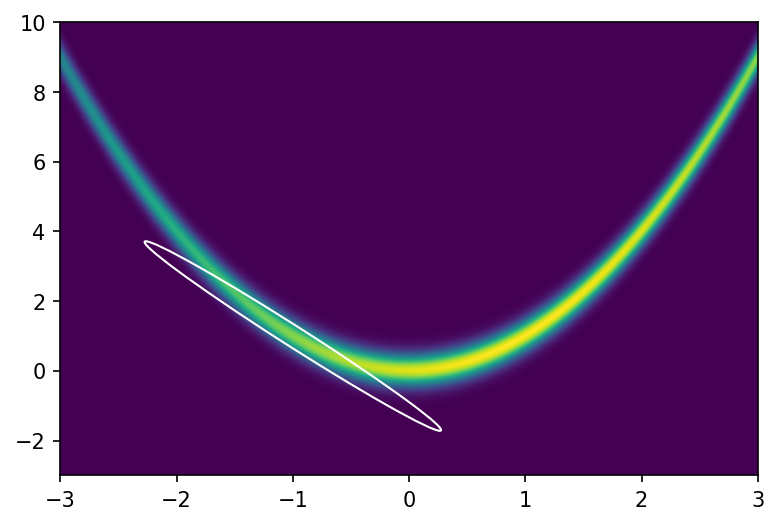

In [3]:
from matplotlib.patches import Ellipse


def rosen(x,y,a,b):
    return np.exp(-((a-x)**2+b*(y-x**2)**2)/20)

a, b = 1, 100
xmin,xmax = -3,3
ymin,ymax = -3,10
x1d = np.linspace(xmin,xmax, 1000)
y1d = np.linspace(ymin,ymax, 1000)
X,Y = np.meshgrid(x1d, y1d)
rho = rosen(X,Y,a,b)

fig,ax = plt.subplots()
im = ax.imshow(rho, vmin=0, vmax=1, extent=(xmin,xmax,ymin,ymax), origin='lower')
ax.set_aspect('auto')

ax.add_artist(Ellipse(xy = (-1,1), width=6, height=0.3, angle=-65, fc='None', ec='w'));

Instead of using the Jacobian of the model function, we will allow the proposal distribution to adapt automatically to the shape of the posterior distribution we are sampling.

If we have already sampled the points $(\mathbf{w}_0,\dots,\mathbf{w}_{n-1})$ the next candidate move will be drawn from a distribution with $\mathbf{\Sigma_n} = \mathrm{cov}(\mathbf{w}_0,\dots,\mathbf{w}_{n-1}) + \epsilon \mathbf{I}_k$, where $\epsilon>0$ is a small regularization parameter to ensure that the covariance matrix is positive definite.

We need to start this off with some known $\mathbf{\Sigma}_0$. We could use the one determined from the Jacobian of the model function, but since $\mathbf{\Sigma}$ will adapt as the Markov chain proceeds, we can use some simpler initial guess, for example a diagonal $\mathbf{\Sigma}$ with the scale factors we have used previously.

Since each new sample will make relatively little difference to the covariance matrix, we can update it every $n$ iterations using the recursive formulas we used in the first assignment.

The sample covariance matrix is
$$ \mathrm{cov}(\mathbf{w}_0,\dots,\mathbf{w}_n) = \frac{1}{n}\left( \sum_{i=0}^n \mathbf{w}_i \mathbf{w}_i^T - (n+1)\overline{\mathbf{w}}_n\overline{\mathbf{w}}_n^T\right) $$
where the $\overline{\mathbf{w}}_k$ are the sample means. Updates can be determined from
the recursion
$$ \mathbf{\Sigma}_{n+1} = \frac{n-1}{n}\mathbf{\Sigma}_n + \frac{1}{n}\left(
n\overline{\mathbf{w}}_{n-1}\overline{\mathbf{w}}_{n-1}^T - (n+1)\overline{\mathbf{w}}_n\overline{\mathbf{w}}_n^T + \mathbf{w}_n\mathbf{w}_n^T + \epsilon \mathbf{I}_k\right) $$
The effect of this adaptation is large at first and then goes down as $1/n$.

A Markov chain with this adaptation can be proved to be ergodic, while a chain which uses only a fixed length of history to determine $\mathbf{\Sigma)}$ is not ergodic (and is not even a Markov chain as it depends upon a fixed number of steps in its history).

Now we have our adaptive covariance matrix, how do we sample from a multivariate normal distribution?

Given our covariance matrix $\mathbf{\Sigma}$, we can compute its Cholesky decomposition into lower- and upper-triangular matrices such that $\Sigma = \mathbf{L}\mathbf{U}$. Since
$\mathbf{\Sigma}$ is symmetric positive-definite, we have that $\mathbf{U} = \mathbf{L}^T$.

The recipe is as follows:
If $\mathbf{\Sigma}$ is a $k\times k$ matrix, then generate a vector of $k$ samples from a normal distribution $\mathbf{z}$. These can be transformed into a sample drawn from the multivariate normal distribution as
$$ \mathbf{x} = \boldsymbol{\mu} + \mathbf{L}\mathbf{z} $$

Text(0.5, 0, 'samples transformed to\nmultivariate normal')

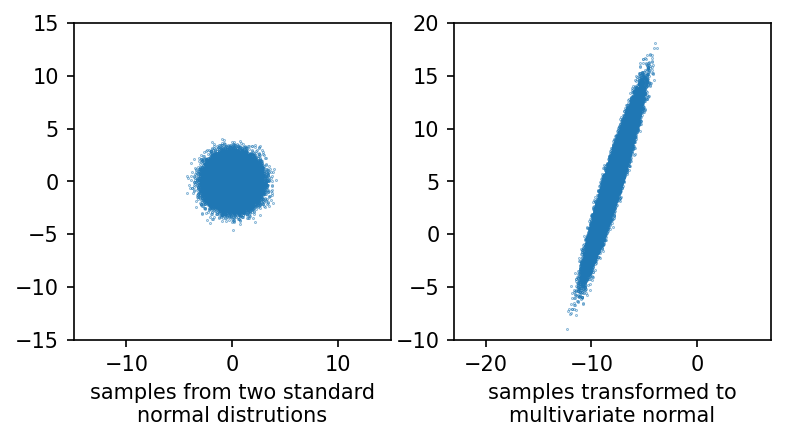

In [4]:
import numpy.random as rng
rng.seed(209313)
N = 100000

# make mean and covariance to sample from 
mean = np.array([-8, 5])
cov = np.array([[1.0, 3], [3, 10.0]])

# get 2N samples from 1D normal distribution
z = rng.randn(N,2)

# transform to 2D normal
eps = 1e-10
L = np.linalg.cholesky(cov + eps*np.eye(cov.shape[0]))
x = (mean[:,np.newaxis] + L@z.T).T

fig, ax = plt.subplots(1,2)
ax[0].scatter(x=z[:,0], y=z[:,1], s=0.05)
ax[0].set_xlim(-15,15)
ax[0].set_ylim(-15,15)
ax[0].set_aspect('equal')
ax[0].set_xlabel('samples from two standard\nnormal distrutions')

ax[1].scatter(x=x[:,0], y=x[:,1], s=0.05)
ax[1].set_xlim(-23,7)
ax[1].set_ylim(-10,20)
ax[1].set_aspect('equal')
ax[1].set_xlabel('samples transformed to\nmultivariate normal')

Numpy.random provides the generator multivariate_normal to do just this. Sadly, it is not yet supported by Numba, but we can write our own:

In [5]:
from numba import njit
import numpy.random as rng
rng.seed(1209313)

@njit
def multivariate_normal(mean, cov, *size):
    n = cov.shape[0]
    # regularization parameter
    eps = 1e-10
    # get standard normal samples
    norm = rng.randn(*size,n).reshape(-1,n)
    # perform the transformation
    return ((np.linalg.cholesky(cov + eps*np.eye(n))@norm.T).T + mean).reshape(*size, n)

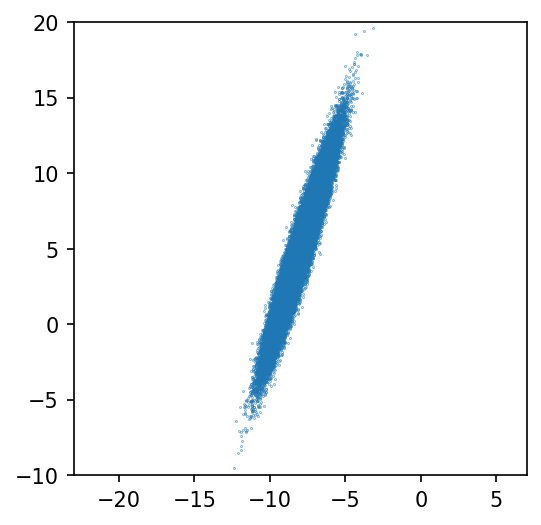

In [6]:
foo = multivariate_normal(mean, cov, N)
fig, ax = plt.subplots()
ax.scatter(x=foo[:,0], y=foo[:,1], s=0.05)
ax.set_xlim(-23,7)
ax.set_ylim(-10,20)
ax.set_aspect('equal')


***


We are now ready to run our adaptive sampling MCMC chain.

The code is to be found in the MCMCutils.py module and consists of:

MCMC:
The MCMC sampler class, with constructor

    MCMC(data, nParam, labels, modelFunction, priorFunction, indivMove, solveSigma, sigParams, seed)
    
where:

          data[N, ncol]: N data points consisting of:
              data[:,0]: independent variable to modelFunction
              data[:,1]: dependent variable to be modeled by modelFunction
              data[:,2]: individual measurement sigma's for each data point 
                         (used only if solveSigma=False)    
        
                 nParam: number of parameters to be sampled (other than sigma if solveSigma=True)
    
                 labels: a numba.typed.List of strings for plot labels
    
    modelFunction(t, w): where t is the independent variable and w a vector of nParam
                         parameters. Returns a vector of N dependent variables.
                         Must be complied with @njit.
                         
       priorFunction(w): prior pdf on parameters w; returns a probability (on [0,1]).
                         Must be complied with @njit.
                      
              indivMove: if True, samples each component of w separately; if False, chooses move
                         from a multivariate normal distribution with a covariance matrix sampled
                         from the Markov chain. Default is False.
               
             solveSigma: if True, data[:,2] is ignored, and a single sigma on the data is added
                         as a parameter to sample. Default is False.
                
           sigParams[2]: sigParams[0] gives the width of the gamma function used to sample sigma
                         and 
                         sigParams[1] gives the mean of the sampled sigma.
                         Both parameters are modified as the Markov chain proceeds.
                         Default parameters are [5.0, 1.0]
                  
                   seed: the random number seed to start the rng. A default seed is provided. 

After obtaining an instance of MCMC, it is run with a call to

    sampler(w0, sig0, iterations, sampleCov, startCov)
where

            w0: starting point for the chain
          sig0: diagonal of the initial covariance matrix
    iterations: number of steps to perform
     sampleCov: interval in steps between updates of covariance matrix
      startCov: starting step after which covariance matrix is updated every sampleCov steps

Also provided are the utilities plotChains and cornerPlot:

    plotChain(M, burn, end)
            M: MCMC class instance used to run the chain
         burn: first element of the chain to be used
          end: last+1 element of the chain to be used (can be -1 for all)
         
    cornerPlot(M, burn, end, truth)
            M: MCMC class instance used to run the chain
         burn: first element of the chain to be used
          end: last+1 element of the chain to be used (can be -1 for all)
        truth: an array of the "correct" parameter values to show on the plots

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from MCMCutils import plotChains, cornerPlot, MCMC

# Numba 
from numba import njit
import numba.typed

# set up random number generator for generating data
# MCMC initializes its own rng with its own seed
import numpy.random as rng
seed = 3848934
rng.seed(seed)
    
plt.rcParams['figure.dpi'] = 150

Here we define the same modelFunction and priorFunction we have been using all along,
and generate some data as before. Note that, due to restrictions from using Numba, the
list of parameter labels must be declared as a numba.typed.List(), not a normal Python list.

In [8]:
@njit
def modelFunction(t: np.ndarray, w: np.ndarray) -> np.ndarray :
    M, dm, dp, pe, P = w[0:5]
    phase = np.mod(t, P)
    return np.where( (phase>pe-dp/2) & (phase<pe+dp/2), M-dm, M)


@njit
def priorFunction(w: np.ndarray) -> float:
    wRange = np.array([[-100.0, 100.0], [0.0, 10.0], [0.0, 1.0], [0.0, 1.0], [0.1, 2.0]], dtype=np.float64)
    for i in range(len(w)):
        if w[i]<wRange[i,0] or w[i]>wRange[i,1]:
            return 0.0
    else:
        return 1.0

    
def getData(N):
    
    # Parameters for the simulated observations:
    M0 = 10.0
    dm0 = 5.0
    dp0 = 0.2
    pe0 = 0.35
    P = 1.0
    
    # sample size:
    N = 100

    # variance on each observation:
    sig = 1

    duration = 10
    
    # vector of "true" parameters
    w0 = np.array([M0, dm0, dp0, pe0, P])
    labels = numba.typed.List(['$M$', '$\Delta m$', '$\Delta p$','$p_e$', '$P$', '$\sigma$'])

    data = np.zeros((N,3))
    data[:,0] = np.sort(rng.uniform(size=N)*duration)
    data[:,1] = modelFunction(data[:,0], w0) + sig*rng.standard_normal(size=N)
    data[:,2] = np.ones(N)*sig

    # find mean and errors of M
    wp = np.zeros_like(w0)
    wp[:] = w0
    wp[0] = 0
    wp[1] = -dm0
    foo = modelFunction(data[:,0], wp) + data[:,1]
    Mmean = foo.mean()
    Msig = np.sqrt(foo.var())

    # find actual dm
    idx = np.where( (data[:,0]>w0[3]-w0[2]/2) & (data[:,0]<w0[3]+w0[2]/2) )[0]
    dmmean = Mmean - data[idx,1].mean()

    truth = np.array([Mmean, dmmean, dp0, pe0, P, Msig])

    fig, ax = plt.subplots()
    ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2])
    ax.errorbar(data[idx,0], data[idx,1], fmt='g.', yerr=data[idx,2])
    xx = np.linspace(0, duration, 10000)
    ax.plot(xx, modelFunction(xx,w0), 'g', label='$w_0$')
    ax.plot(xx, modelFunction(xx,truth), 'cyan', label='truth', lw=5, zorder=0)
    ax.set_xlabel('orbital phase')
    ax.set_ylabel('M')
    ax.legend()

    # guess at parameter variances
    sig0 = np.array([1,1,1,1,1], dtype=np.float64)
    
    return w0, sig0, data, labels, truth

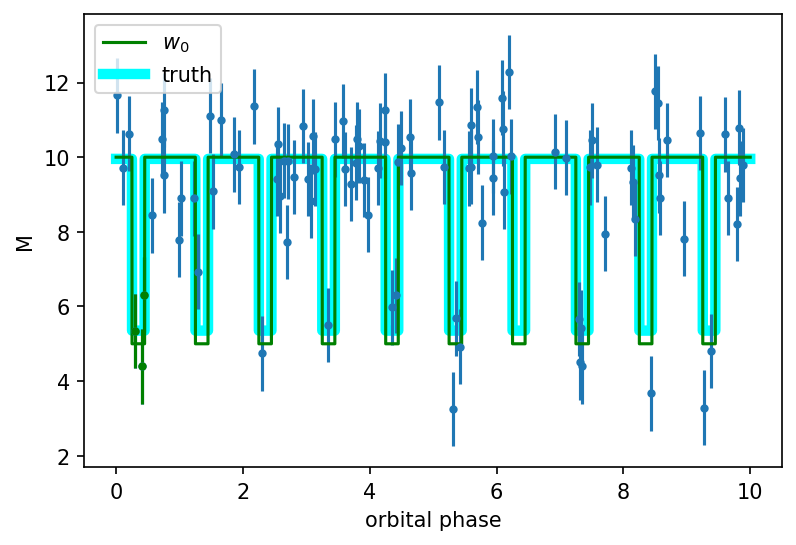

In [9]:
w0, sig0, data, labels, truth = getData(100)

Run the MCMC sampler, fitting for the data variance as a parameter (solveSigma=True) and sampling moves from a multivariate normal distribution whose covariance is computed from the samples (indivMove=False).

We deliberately pick a fairly small initial variance for $P$ since picking $P$ as an integer multiple of the true period can be compensated by a larger $\sigma$. There is one eclipse with no data, and four with one data point out of ten eclipses. Just from looking at the data, our prior on the period could be much tighter. 

In [53]:
sigParams = np.array([3.0, 1.0])

M = MCMC(data, 5, labels, modelFunction, priorFunction, 
         indivMove=False, solveSigma=True, sigParams=sigParams, seed=12376513)

wStart = np.array([9.0, 6.0, .1, .1, 1.5])
sigStart = np.array([1.0, 2.0, 1, 1, 3])

M.sampler(wStart, sigStart, 5*10**6, 10000, 10000)

Plot the chain. Clearly, it takes more than 250K steps to mix

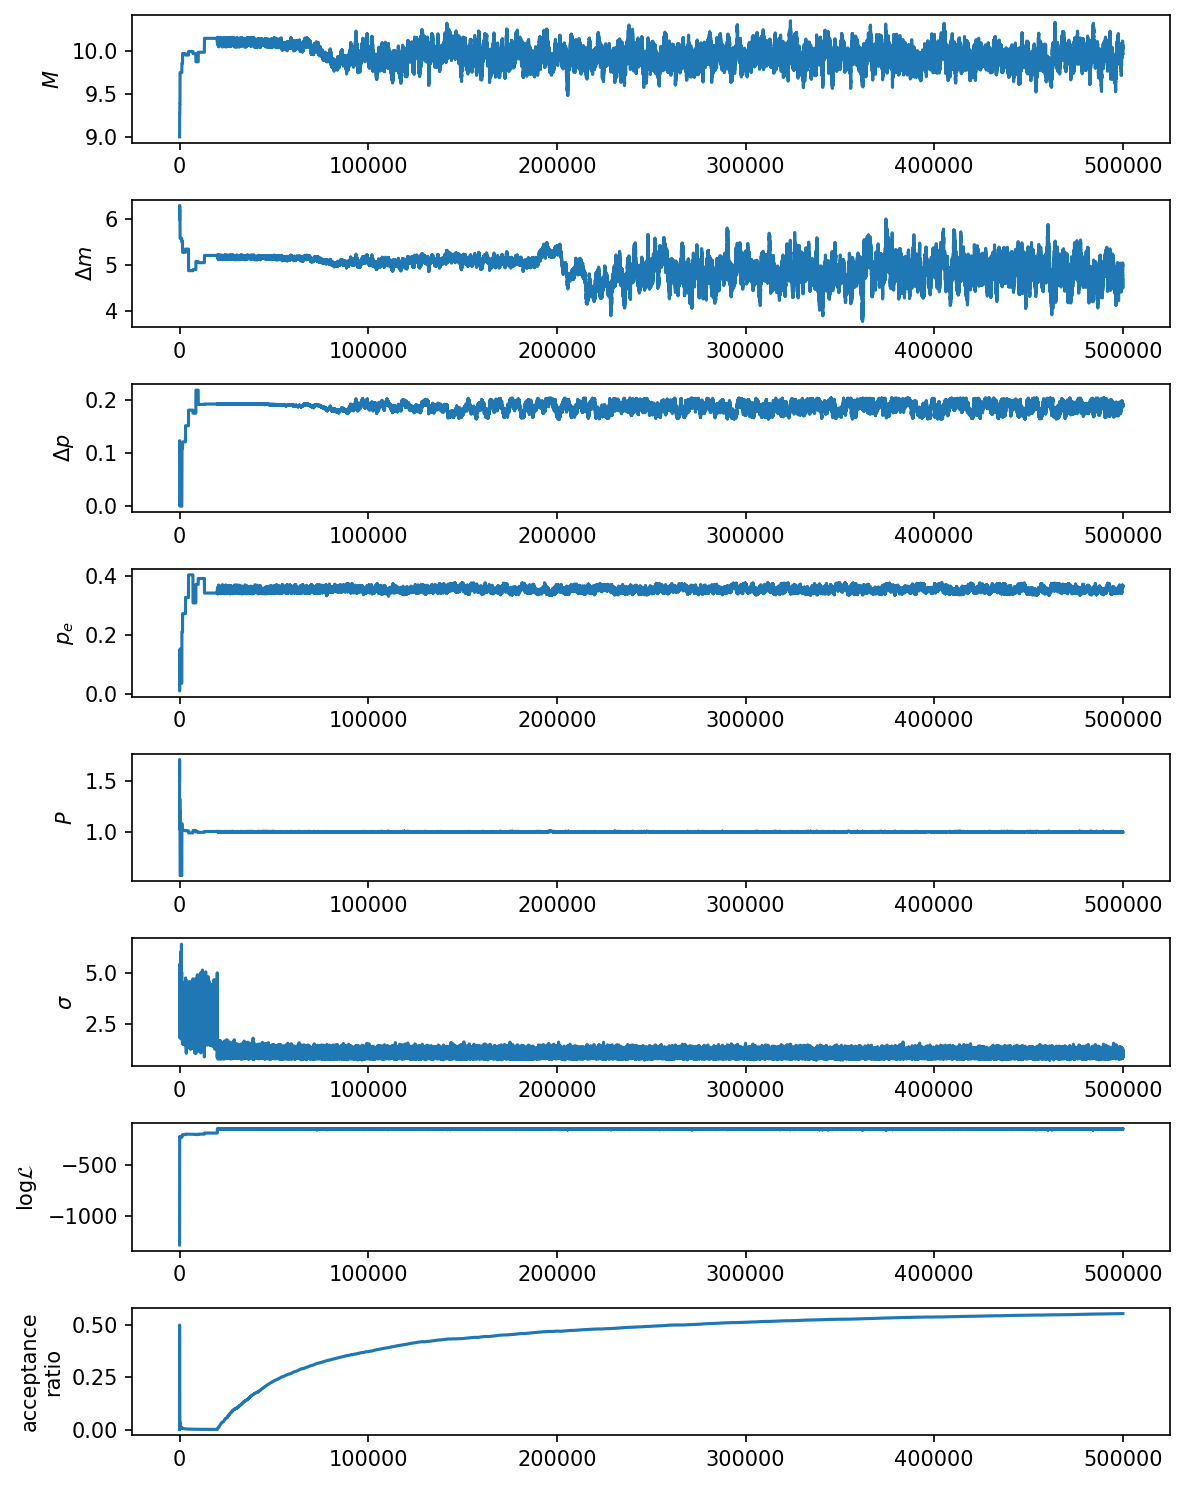

In [62]:
burn = 0
end  = 500000
plotChains(M, burn, end)

After something like $3\times10^5$ steps, the chain appears to have mixed:

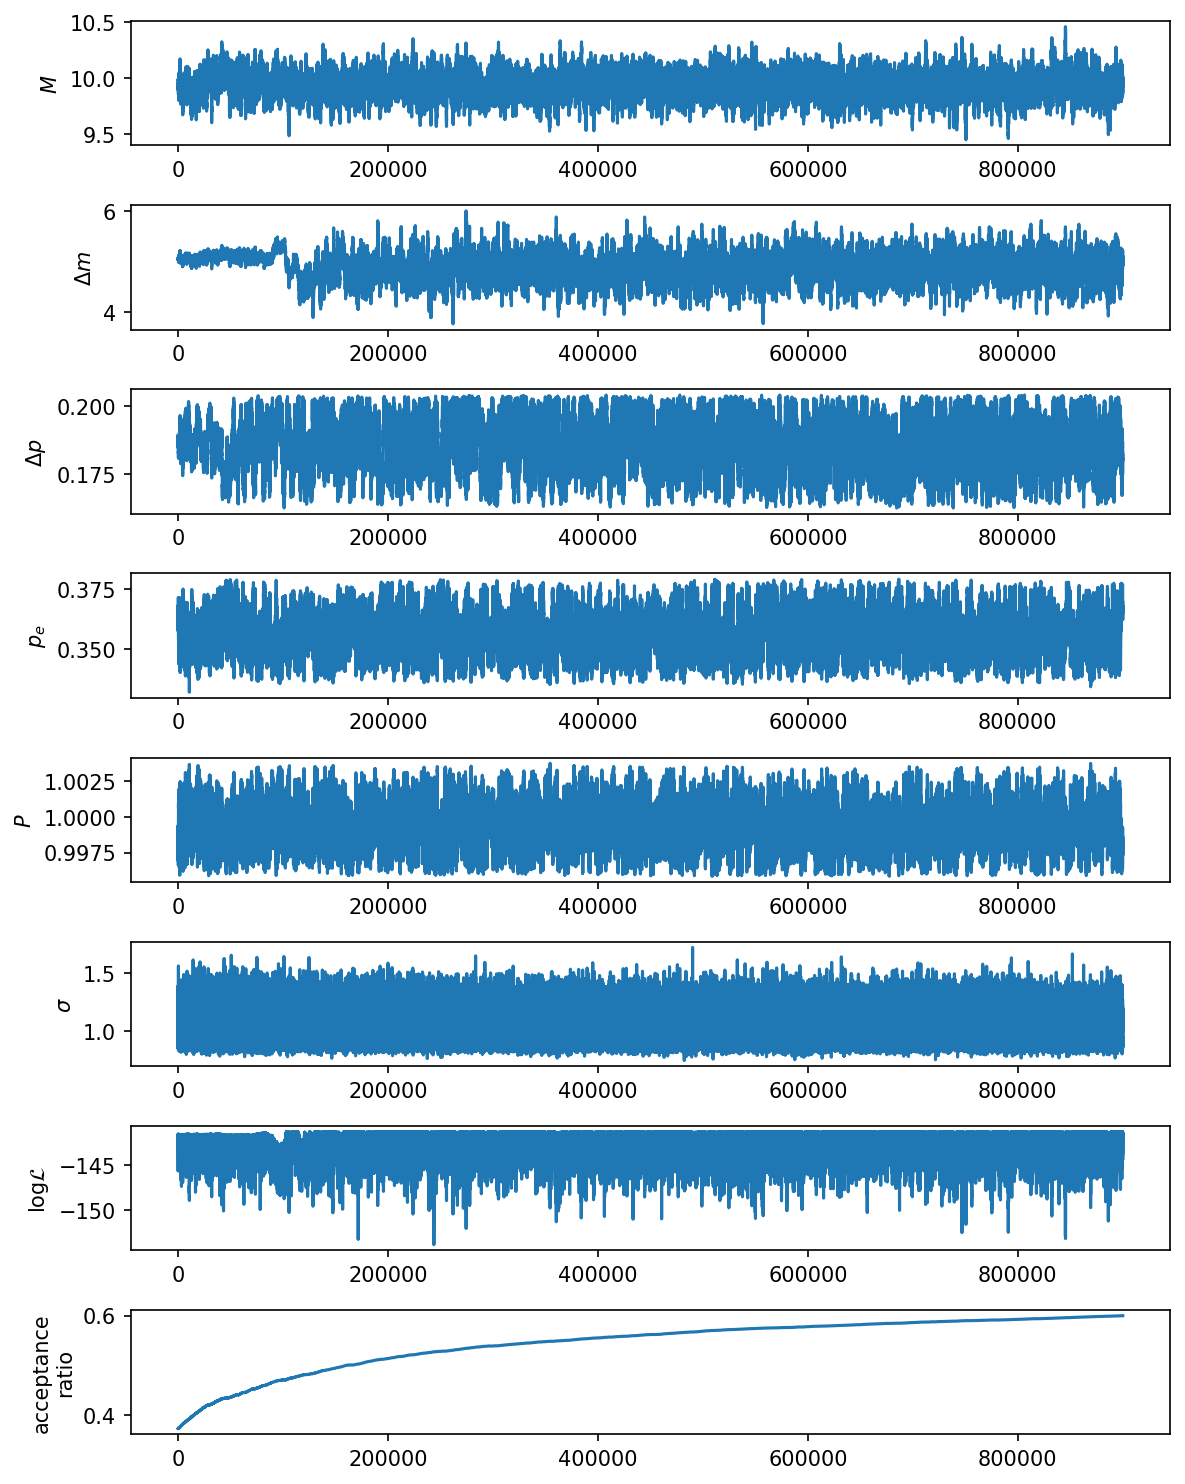

In [63]:
burn = 100000
end  = 10**6
plotChains(M, burn, end)

Looking near the end of the run shows that the chain appears to have indeed mixed in all parameters, thought the typical move might be larger...

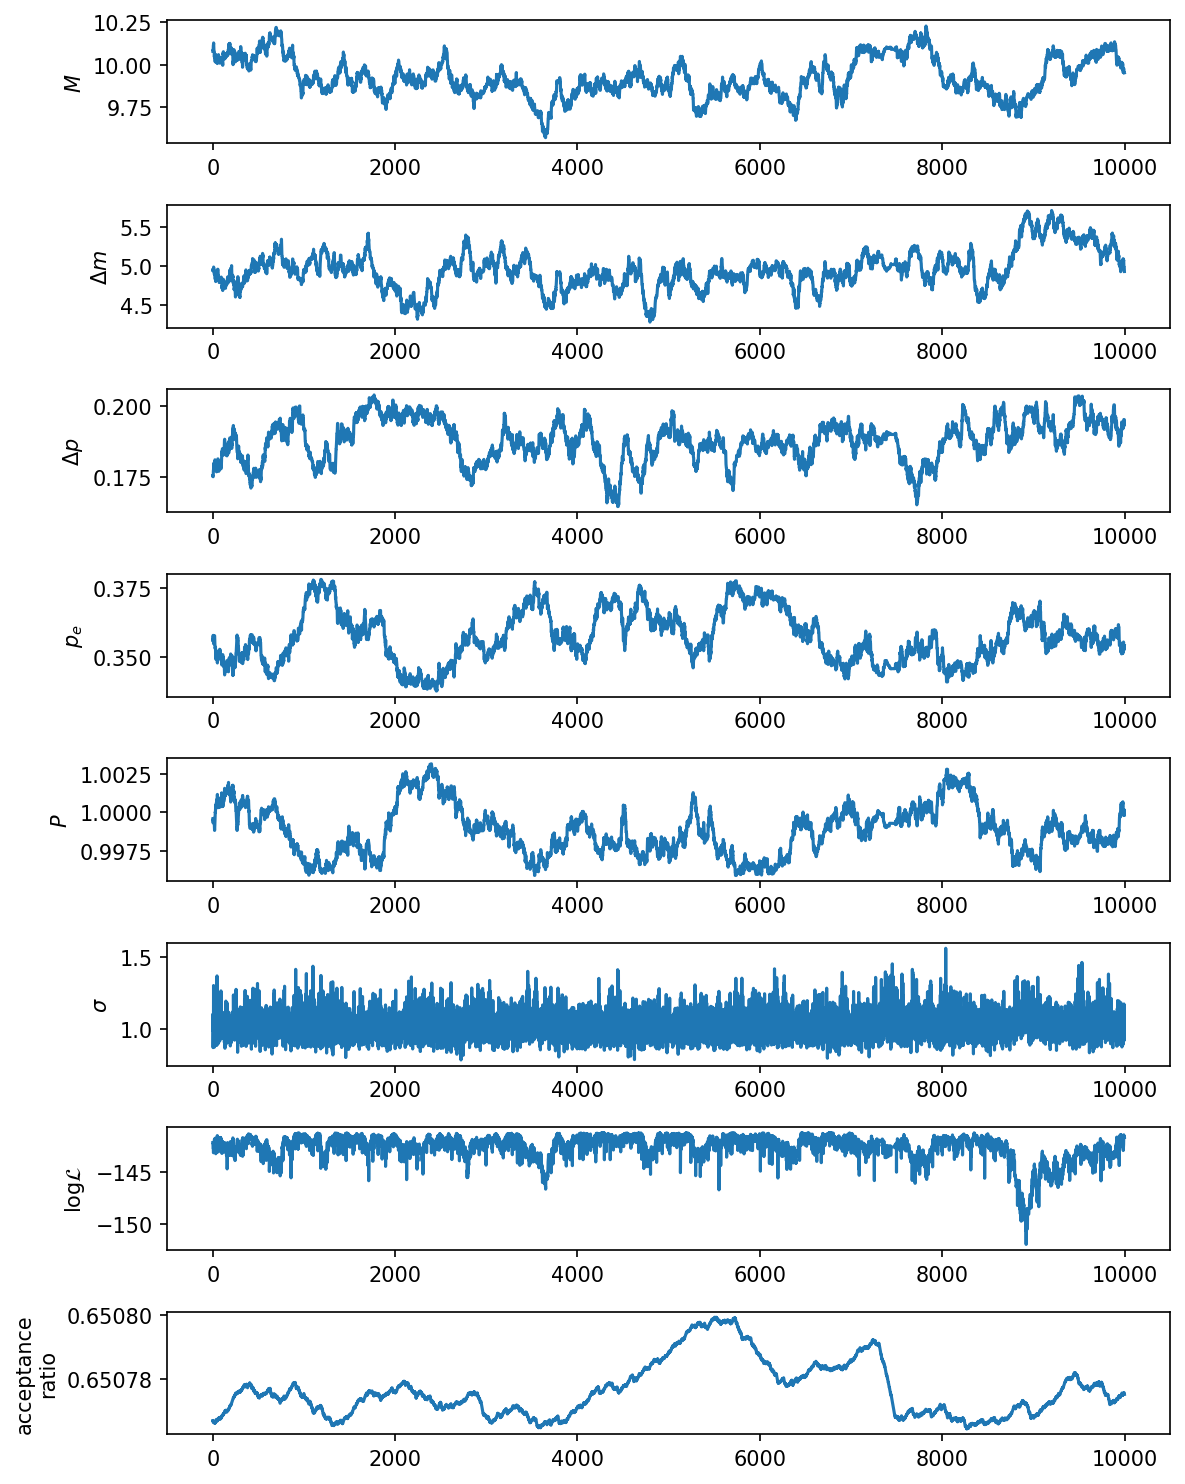

In [56]:
burn = 4 * 10**6
end  = 4 * 10**6 + 10000
plotChains(M, burn, end)

We will thus omit the first $10^6$ steps of the chain:

In [64]:
burn = 1 * 10**6
end = -1

Make a corner plot to show the distributions. Note the high degree of correlation between $\Delta p$ and $p_e$ and
the gamma distribution of the sampled $\sigma$'s:

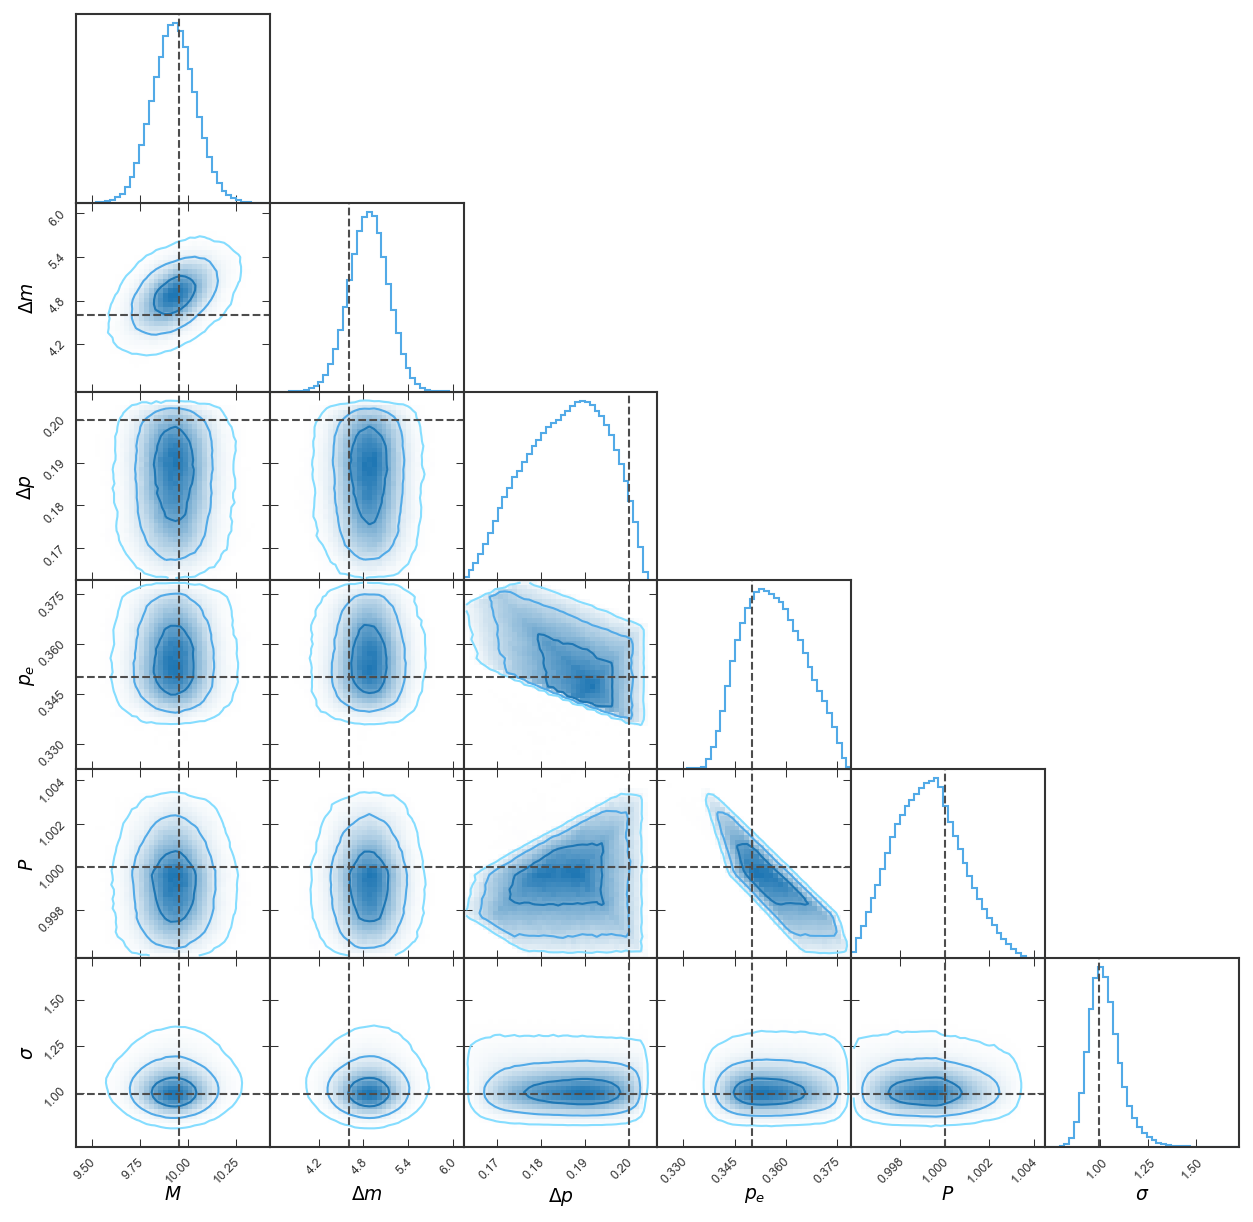

In [65]:
cornerPlot(M, burn, end, truth)

Find the mean of the parameter distribution over the last $10^5$ samples from the Markov chain and plot the model with these parameters against the data. The green line is the parameter values from which the "fake" data was sampled, the wide cyan line is the model with the sample mean for $M$ and $\Delta m$, and the red line corresponds to the mean of the sampled parameter values:

[9.93441824 4.89562248 0.18476874 0.3575961  0.99916531]


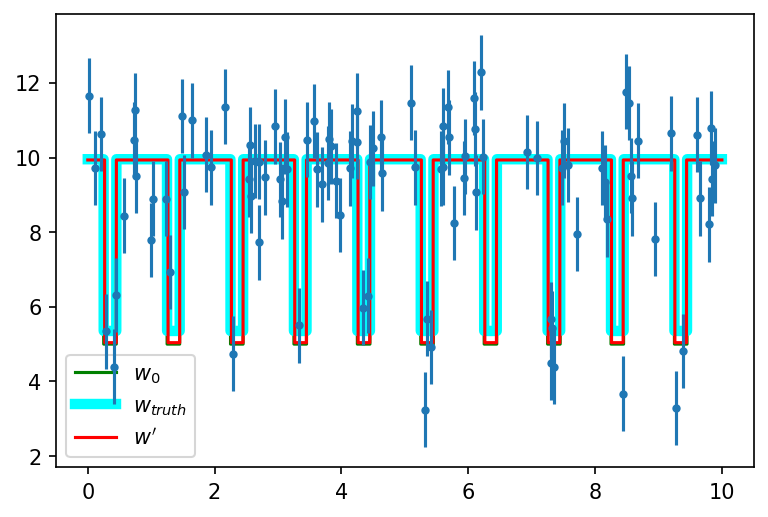

In [66]:
wp = np.mean(M.chain[-100000:,:], axis=0)
print(wp)
fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2], zorder=100)
xx = np.linspace(0, 10, 10000)
ax.plot(xx, modelFunction(xx,w0), 'g', label='$w_0$')
ax.plot(xx, modelFunction(xx,truth), 'cyan', label='$w_{truth}$', lw=5)

ax.plot(xx, modelFunction(xx,wp), 'r',label='$w^\prime$')
ax.legend();

Note that $\Delta p$ is not very well constrained by the data; there are no data point near enough to
$p = 0.25$ to provide a constraint.

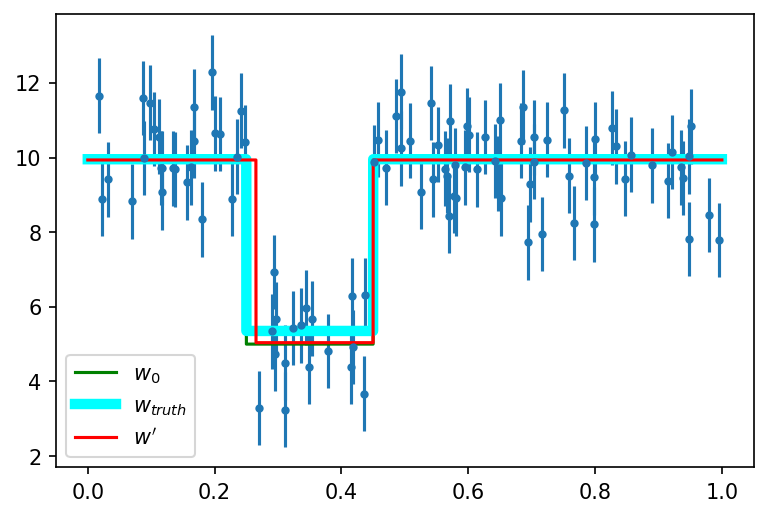

In [67]:
fig, ax = plt.subplots()
ax.errorbar(np.mod(data[:,0],w0[4]), data[:,1], fmt='.', yerr=data[:,2])
xx = np.linspace(0, 1, 10000)
ax.plot(xx, modelFunction(xx,w0), 'g', label='$w_0$')
ax.plot(xx, modelFunction(xx,truth), 'cyan', label='$w_{truth}$', lw=5)

ax.plot(xx, modelFunction(xx,wp), 'r',label='$w^\prime$')
ax.legend();